# Description of Raw Data

This notebook is used to visualize the Raw Data from the Gesture Glove Experiments.

In [1]:
# imports
import pandas as pd
import numpy as np
import scipy as sp
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import pickle
import tqdm
import random
from datetime import datetime, timedelta
import gestureanalysis.read_raw as rr
import gestureanalysis.raw_preprocessing_and_cleaning as rp
import gestureanalysis.utils as utils
import gestureanalysis.specific_utils as sutils
from gestureanalysis.constants import Constants
import operator

In [2]:
base_path = "/home/jsimon/Documents/thesis/gesture-analysis/data/"
base_path_raw = base_path+"raw/all"
base_path_pickl = base_path+"transformed/raw-pickeled/all/raw-all.pkl"
time_path_pickl = base_path+"transformed/time_added/all/time-all.pkl"
time_groups_path_pickl = base_path+"transformed/time_added/all/time-and-groups-all.pkl"

In [3]:
# check working directory and adopt if needed
import os
os.getcwd()

'/home/jsimon/Documents/thesis/gesture-analysis/scripts'

## Structure of Raw Data

In the experiment the data was saved autmatically the following way: For each participant a folder with the participant code was created. In that folder a file in the Format *CODE_TYPE_TIMESTAMP.csv* was created, with _CODE_ beeing the participant code, _TYPE_ being one of gesture, myo or labels, timestamp being in the format *Year_Month_Day_Hour_Minute_Second*. An example would be *PS42_glove_2015_08_13_15_06_08.csv*. 

The type glove means it has all the channels for the glove, myo has all the channels for the myo, labels has start and end index for glove and myo for each time a label was recorded in a row. If you combine all the raw data into one big python pickle we have around __3.4 GB__ of raw data.

If an experiment was interrupted inbetween because there was a break needed or a problem with a sensor, it could be picked up at a later time. In this case several of the above files exists in the users folder, with a different starting timestamp.

The function *rr.read_raw(base_path_raw)* iterates trough a directory with user data reading the folders name as username and reads all the _.csv_ into keys for that user. In this first collection each file is read into a individual pandas dataframe, and saved into the users dictionary under the key 'glove', 'myo' or 'label' with it's filename.

In [4]:
# load all csvs into a dictionary called users
def read_users():
    return rr.read_raw(base_path_raw)
users = utils.try_pickl_or_recreate(base_path_pickl, read_users)

## Preprocessing

The intial preprocessing consists in adding the labels, changing the indes to the time domain, and with that combining the individual data files (there is only more than one if interruptions occured) into one file with a time domain index

- First the labeling info is added back into the data for the glove and the myo data. This should be done first as the labels are collected with a start and end index number relative to the recording number in that file. There exist 4 Types of labels:
 - Automatic: the user is asked by the prgram of the experiment to perform the gesture after a countoun within three seconds. The start and the end index of this window is tagged with the label_automatic type
 - Manual: The manual label is the combination of the dynamic and the static label, and recorded as the label_manual type
 - Dynamic: When the user performs a gesture a experimenter manually pressed 1 when the dynamic part of a gesture was taken place. The dynamic part is defined as the part where arm and/or fingers move to form a gesture. The start and the end index of this manual labeling is recorded in the label_dynamic type.
 - Static: When the dynamic part ends, often a static part is added to a gesture. The static part is where the arm rests in a pose forming the symobolic shape the gesture represents (like thumbs up). If that part is present the experimenter manually labels that part by pressing 2. The start and end frame is recordet into the label_static type.

- After that the timension of time must be correctly recovered: Each recording has a file with a timestamp. This timestamp is used as a base. After initial reading each pandas file is indexed from *0* to _len(records)_. This can be used to recover the time domain by using the base timestamp and adding the index number multiplied by the time delta between each recording. We used a fixed frequency of 83.3Hz or a time delta of 0.012.
- Up to this point, if a recording was breaked into two sessions, each file was processed individually, because the index is relative to a file, and needed for recovery of the frames a label belongs to. Since now the labels are correctly combined and the time domain is added, we can concatenate the individual recordings to one big recording. This is saved into the "glove_merged" key into each users data dictionary.

In [5]:
def add_labels(gdata, ldata):
    # add labels:

    gdata['label_automatic'] = np.NaN
    gdata['label_manual'] = np.NaN
    gdata['label_dynamic'] = np.NaN
    gdata['label_static'] = np.NaN

    # prepare annotated Automatic Labels:
    automatic = ldata[ldata['manual_L_vs_automatic_G'] == 'G']
    manual = ldata[ldata['manual_L_vs_automatic_G'] == 'L']
    dynamic = manual[manual['aut0_dyn1_static2'] == 1]
    static = manual[manual['aut0_dyn1_static2'] == 2]

    for _, row in automatic.iterrows():
        rp.add_label(gdata, row, 'label_automatic')
    for _, row in manual.iterrows():
        rp.add_label(gdata, row, 'label_manual')
    for _, row in dynamic.iterrows():
        rp.add_label(gdata, row, 'label_dynamic')
    for _, row in static.iterrows():
        rp.add_label(gdata, row, 'label_static')


def transform_index_to_time(fname, gdata, data):
    fdate = fname[-23:-4]
    startdate = datetime.strptime(fdate, "%Y_%m_%d_%H_%M_%S")

    offsets = gdata.index.values * Constants.dt_t
    times = startdate + offsets
    tmp = pd.to_datetime(times)
    gdata.index = tmp

    if 'glove_merged' in data:
        old_data = data['glove_merged']
        data['glove_merged'] = old_data.append(gdata)
    else:
        data['glove_merged'] = gdata

# preprocess users iterates the users array, and applies the add_labels function and 
# transfrom_index_to_time to each data frame
rp.preprocess_raw(users, add_labels, transform_index_to_time)

  4%|▍         | 1/23 [00:09<03:25,  9.33s/it]

ignore user  AE30
ignore user  AE30


100%|██████████| 23/23 [01:42<00:00,  5.19s/it]


In [6]:
# in case the script above worked, execute that line:
with open( time_path_pickl, "wb" ) as users_pickle_file:
    pickle.dump(users, users_pickle_file)

In [7]:
# in case you need to reload, and know it exists:
with open( time_path_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

### Recovering Label Groups

We now added to labels from the labels file to each row of the geasture data. After that we recovered the time domain, so the dataset now has concrete dates for each row as index. The problem with that is that we now lost the start and end index for each label. An easy was ist just to go trough the original data, and recover the groups by scanning trough the index and define every consecutive streak of label data as one group. Concretely if a occurence of a label is found, as long as there are new rows with the same label within three times the time delate of 0.013s the next row is counted towards the same group. as soon as this requirenment breaks the group is closed and with the next labeled row the new group started.

In [8]:
duration_allowed_error = Constants.dt_t*3
dae = duration_allowed_error
z = timedelta(milliseconds=0)

def label_groups_for_one_label_type(label_type, glove_merged):
    g_lbls = glove_merged[glove_merged[label_type].notnull()]
    index = g_lbls.index.tolist()
    groups = utils.find_consecutive_groups(index, Constants.dt_t*2, use_tqdm=False)
    return groups

def recover_label_groups_from_data(user_data):
    glove_merged = user_data['glove_merged']
    
    groups = label_groups_for_one_label_type("label_automatic", glove_merged)
    user_data['start_end_automatic_groups'] = groups
    
    groups = label_groups_for_one_label_type("label_manual", glove_merged)
    user_data['start_end_manual_groups'] = groups
    
    groups = label_groups_for_one_label_type("label_dynamic", glove_merged)
    user_data['start_end_dynamic_groups'] = groups
    
    groups = label_groups_for_one_label_type("label_static", glove_merged)
    user_data['start_end_static_groups'] = groups

def recalc_deltas_and_pins(user_data):
    pins = deltas_from_group(user_data, "label_automatic", "start_end_automatic_groups")
    user_data['stats_automatic'] = pins
    
    pins = deltas_from_group(user_data, "label_manual", "start_end_manual_groups")
    user_data['stats_manual'] = pins
    
    pins = deltas_from_group(user_data, "label_dynamic", "start_end_dynamic_groups")
    user_data['stats_dynamic'] = pins
    
    pins = deltas_from_group(user_data, "label_static", "start_end_static_groups")
    user_data['stats_static'] = pins

def deltas_from_group(user_data, label_type, group_name):
    glove_merged = user_data['glove_merged']
    g_lbls = glove_merged[glove_merged[label_type].notnull()]
    groups = user_data[group_name]
    deltas = [(end-start) for (start, end) in groups]
    pins = [[z, 0, z],[z, 0, z],[z, 0, z],[z, 0, z]]
    drop_deltas = []
    for d in deltas:
        l,h = groups[deltas.index(d)]
        selection = g_lbls[l:h]
        calc_duration = len(selection) * Constants.dt_t
        if rp.is_wrong_label(d, calc_duration, dae):
            g_lbls.drop(selection.index, inplace=True)
            drop_deltas.append(d)
            continue
        rp.collect_stats(d, calc_duration, pins)
    return pins

for key, data in tqdm.tqdm(users.items()):
    if not 'glove_merged' in data:
        continue
    recover_label_groups_from_data(data)
    recalc_deltas_and_pins(data)


def print_summary(label_type, count, duration, calc_duration):
    if count > 0:
        print(f"there are {count} {label_type}, who take {duration/count} time on avarage and should take {calc_duration/count}")
    else:
        print(f"there are no examples for {label_type}")

def summary_for(pin_type, user_data):
    pins = user_data[pin_type]
    print("")
    print("pin type: ", pin_type)
    print_summary("short labels",    pins[0][1], pins[0][0], pins[0][2])
    print_summary("low mid labels",  pins[1][1], pins[1][0], pins[1][2])
    print_summary("high mid labels", pins[2][1], pins[2][0], pins[2][2])
    print_summary("long labels",     pins[3][1], pins[3][0], pins[3][2])

for pin_type in ['stats_automatic', 'stats_manual', 'stats_dynamic', 'stats_static']:
    for key, data in users.items():
        summary_for(pin_type, data)

# then visualize

100%|██████████| 23/23 [00:33<00:00,  1.56s/it]


pin type:  stats_automatic
there are no examples for short labels
there are no examples for low mid labels
there are 309 high mid labels, who take 0 days 00:00:03.061592 time on avarage and should take 0:00:03.073592
there are no examples for long labels


KeyError: 'stats_automatic'

An alternative is to look up in the original parts of a file, and recover the start and end times there. If you do both you can compare the results to have an integrity check of the data within the labels.

In [ ]:
# check original label data

In [6]:
# in case the script above worked, execute that line:
with open( time_groups_path_pickl, "wb" ) as users_pickle_file:
    pickle.dump(users, users_pickle_file)

In [3]:
# in case you need to reload, and know it exists:
with open( time_groups_path_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

Sometimes the hardware did not give correct values. In that case the records where set to NaN. If such a record falls outside a label, it is just deleted. If it is inside a label we need to check if the label did not loose to much data. If more than 10% of the records of a label are corrupted, we delete the whole label. Additionally we sometimes had (mostly out of hardware errors) to restart an experiment. If that was while a labels was recorded, the automatic labeling would not have it's standart width. Therefor we need to discard all data where the automatic labeling does not have the standart amound of time.

In [ ]:
# do that check

Next I want to show the basic structure of the data.

In [6]:
users['AF82']['filecount']

11

In [9]:
# correct corrupted labels
print(users.keys())

dict_keys(['AB73', 'AE30', 'AF82', 'AL29', 'AW18', 'CB23', 'CB24', 'CF58', 'DG12', 'DH42', 'DL24', 'JL61', 'JQ28', 'JS52', 'MF20', 'MS55', 'PC29', 'PM32', 'PS42', 'RR45', 'RW32', 'SF1', 'YW13'])


In [8]:
if 'glove_merged' not in users['AE30']:
    users['AE30']['glove_merged'] = []
num_users = len(users)
filecounts = [data["filecount"] for usr, data in users.items()]
glove_records = [len(data["glove_merged"]) for usr, data in users.items()]
sts = zip(filecounts, glove_records)

print(f"we have {num_users} participants. ")
print(f"on avarage we have:")
print(f" glove records: {sum(glove_records)/num_users}")
print(f" avarage time: {(sum(glove_records)/num_users)*Constants.dt_t}")
print("")
for s in sts:
    print(f"files: {s[0]}, glove records: {s[1]}")

we have 23 participants. 
on avarage we have:
 glove records: 126742.39130434782
 avarage time: 0:25:20.908696

files: 3, glove records: 183008
files: 10, glove records: 0
files: 11, glove records: 105835
files: 3, glove records: 184276
files: 3, glove records: 103159
files: 3, glove records: 105331
files: 6, glove records: 106082
files: 43, glove records: 119296
files: 3, glove records: 104551
files: 3, glove records: 110435
files: 3, glove records: 181278
files: 34, glove records: 112566
files: 3, glove records: 191596
files: 3, glove records: 187429
files: 3, glove records: 103021
files: 28, glove records: 108852
files: 3, glove records: 120138
files: 3, glove records: 180668
files: 6, glove records: 105795
files: 3, glove records: 105651
files: 3, glove records: 105821
files: 3, glove records: 103205
files: 3, glove records: 187082


In [4]:
def select_gesture(users, username, gesture, label_type = "label_manual"):
    glove_merged = users[username]['glove_merged']
    g_lbls = glove_merged[glove_merged[label_type] == gesture]
    index = g_lbls.index.tolist()
    groups = utils.find_consecutive_groups(index, Constants.dt_t*2)
    if len(groups) == 0:
        return g_lbls, groups, 0
    deltas = [(end-start) for (start, end) in groups]
    smallest_distance = min(deltas)
    return g_lbls, groups, smallest_distance

def create_figs_per_column(path, gesture, smallest_distance, list_of_dfs, average, std):
    for col in average.columns:
        av = average.loc[:,col]
        ax = av.plot(linewidth=3, figsize=(18, 5))
        ax.set_title(gesture + ', channel: ' + col + ', duration: ' + str(smallest_distance.total_seconds()) + 's')
        s = std.loc[:,col]
        ax.fill_between(av.index, av-s, av+s, color='b', alpha=0.2)
        for inst in list_of_dfs:
            inst.loc[:,col].plot(subplots=True, ax=ax, alpha=0.7, linewidth=0.5, legend=False)
        plt.savefig(path+col+'.png')
        #plt.show()
        plt.close()

In [5]:
usernames = users.keys()
#usernames = ['MS55', 'PC29', 'PM32', 'PS42', 'RR45', 'RW32', 'SF1', 'YW13']
#usernames = ['YW13']
gestures = users['AB73']['label'][0]['data']['gesture'].unique()

In [4]:
# visualization: what can we do here?
# pick a random label, plot avaraged signal + std
# plot all signals overlaying each other
# plot one example of very average signal, plot two very different examples
#
# plot labels with similar avarage raw signals
# 
# plot zero label examples near raw signals

# all for one random user or over all users:

for username in usernames:
    for gesture in gestures:
        print('creating figures for ' + gesture + ' of ' + username)
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        fig_base_path = '../figures/raw/'+username+'/'+gesture+'/'
        pathlib.Path(fig_base_path).mkdir(parents=True, exist_ok=True)
        g_lbls, groups, smallest_distance = select_gesture(users, username, gesture)
        if len(groups) == 0:
            print('skipping gesture ' + gesture + ' for user ' + username + ' because we have no data!!!')
            continue
        g_lbls = sutils.drop_labels_and_unused(g_lbls)
        all_instances = sutils.split_df_by_groups(g_lbls, groups, delta=smallest_distance)
        average = utils.average_of_frames(all_instances)
        std = utils.std_of_frames(all_instances, average=average)
        create_figs_per_column(fig_base_path, gesture, smallest_distance, all_instances, average, std)


creating figures for (2) Two of YW13
creating figures for Thumbs down of YW13
creating figures for (5) Five of YW13
creating figures for Knocking of YW13
creating figures for Swipe left of YW13
creating figures for Grasp 2 of YW13
creating figures for Continue of YW13
creating figures for (3) Three of YW13
creating figures for Talking of YW13
creating figures for Shoot of YW13
creating figures for (1) One of YW13
creating figures for Shoulder pat of YW13
creating figures for (4) Four of YW13
creating figures for Cutthroat of YW13
creating figures for Down of YW13
creating figures for Turn of YW13
creating figures for Swipe right of YW13
creating figures for Walking of YW13
creating figures for Point to self of YW13
creating figures for Go away of YW13
creating figures for Grasp 1 of YW13
creating figures for Calling of YW13
creating figures for Swipe up of YW13
creating figures for Never mind of YW13
creating figures for Push away of YW13
creating figures for Thumbs up of YW13
creating

In [ ]:
usernames = users.keys()
for gesture in gestures:
    print('creating avarage for ' + gesture)
    really_all_instances = []
    min_distances = []
    for username in usernames:
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        _, _, smallest_distance = select_gesture(users, username, gesture)
        if (smallest_distance != 0):
            min_distances.append(smallest_distance)
    min_distance = sum(min_distances, timedelta(0))/len(min_distances)
            
    for username in usernames:
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        g_lbls, groups, _ = select_gesture(users, username, gesture)
        if len(groups) == 0:
            print('skipping gesture ' + gesture + ' for user ' + username + ' because we have no data!!!')
            continue
        g_lbls = sutils.drop_labels_and_unused(g_lbls)
        all_instances = sutils.split_df_by_groups(g_lbls, groups, delta=min_distance)
        really_all_instances = really_all_instances + all_instances
        print(f'collected {len(all_instances)} examples for {gesture} from {username}')
        all_instances = None
    
    print(f'collected {len(really_all_instances)} examples for {gesture}')
    average = utils.average_of_frames(really_all_instances)
    std = utils.std_of_frames(really_all_instances, average=average)
    
    fig_base_path = '../figures/raw/ALL_USERS/'+gesture+'/'
    pathlib.Path(fig_base_path).mkdir(parents=True, exist_ok=True)
    
    create_figs_per_column(fig_base_path, gesture, min_distance, really_all_instances, average, std)

creating avarage for (2) Two
skipping userAE30
collected 10 examples for (2) Two from AB73
skipping userAE30
collected 5 examples for (2) Two from AF82
collected 10 examples for (2) Two from AL29
collected 4 examples for (2) Two from AW18
collected 4 examples for (2) Two from CB23
collected 4 examples for (2) Two from CB24
collected 4 examples for (2) Two from CF58
collected 4 examples for (2) Two from DG12
collected 4 examples for (2) Two from DH42
collected 9 examples for (2) Two from DL24
collected 4 examples for (2) Two from JL61
collected 10 examples for (2) Two from JQ28
collected 12 examples for (2) Two from JS52
collected 4 examples for (2) Two from MF20
collected 7 examples for (2) Two from MS55
collected 4 examples for (2) Two from PC29
collected 9 examples for (2) Two from PM32
collected 4 examples for (2) Two from PS42
collected 4 examples for (2) Two from RR45
collected 4 examples for (2) Two from RW32
collected 5 examples for (2) Two from SF1
collected 9 examples for (2) 

collected 4 examples for (3) Three from RR45
collected 4 examples for (3) Three from RW32
collected 4 examples for (3) Three from SF1
collected 9 examples for (3) Three from YW13
collected 128 examples for (3) Three
creating avarage for Talking
skipping userAE30
collected 9 examples for Talking from AB73
skipping userAE30
collected 4 examples for Talking from AF82
collected 9 examples for Talking from AL29
collected 4 examples for Talking from AW18
collected 4 examples for Talking from CB23
collected 4 examples for Talking from CB24
collected 4 examples for Talking from CF58
collected 4 examples for Talking from DG12
collected 4 examples for Talking from DH42
collected 9 examples for Talking from DL24
collected 4 examples for Talking from JL61
collected 9 examples for Talking from JQ28
collected 9 examples for Talking from JS52
collected 4 examples for Talking from MF20
collected 4 examples for Talking from MS55
collected 4 examples for Talking from PC29
collected 9 examples for Talkin

In [8]:
#usernames = users.keys()
all_for_all_gestures = []
lt = "label_automatic"
for gesture in gestures:
    print('gesture timings for ' + gesture)
    all_deltas = []
    for username in tqdm.tqdm(usernames):
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        g_lbls, groups, smallest_distance = select_gesture(users, username, gesture, label_type=lt)
        deltas = [(end-start) for (start, end) in groups]
        #print('timings for ' + gesture + ' of user: ' + username)
        fig_base_path = '../figures/raw/'+username+'/'+gesture+'/'
        plt.hist( list(map(lambda x: x.total_seconds(), deltas)) )
        plt.savefig(f'{fig_base_path}timing_of_{lt}.png')
        plt.close()
        all_deltas += deltas
    print('total timings for ' + gesture)
    fig_base_path = '../figures/raw/ALL_USERS/'+gesture+'/'
    plt.hist( list(map(lambda x: x.total_seconds(), all_deltas)) )
    plt.savefig(f'{fig_base_path}timing_of_{lt}.png')
    plt.close()
    all_for_all_gestures += all_deltas
print('total timings for all gestures over all users')
fig_base_path = '../figures/raw/ALL_USERS/'
plt.hist( list(map(lambda x: x.total_seconds(), all_for_all_gestures)) )
plt.savefig(f'{fig_base_path}timing_of_{lt}.png')
plt.close()

  0%|          | 0/23 [00:00<?, ?it/s]

gesture timings for (2) Two


 13%|█▎        | 3/23 [00:00<00:04,  4.56it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for (2) Two
gesture timings for Thumbs down


 13%|█▎        | 3/23 [00:00<00:04,  4.95it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Thumbs down
gesture timings for (5) Five


 13%|█▎        | 3/23 [00:00<00:03,  5.59it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for (5) Five
gesture timings for Knocking


 13%|█▎        | 3/23 [00:00<00:03,  5.86it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Knocking
gesture timings for Swipe left


 13%|█▎        | 3/23 [00:00<00:03,  5.10it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Swipe left
gesture timings for Grasp 2


  4%|▍         | 1/23 [00:00<00:12,  1.69it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Grasp 2
gesture timings for Continue


 13%|█▎        | 3/23 [00:00<00:02,  7.77it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Continue
gesture timings for (3) Three


 13%|█▎        | 3/23 [00:00<00:04,  4.56it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for (3) Three
gesture timings for Talking


 13%|█▎        | 3/23 [00:00<00:02,  7.43it/s]

skipping userAE30


100%|██████████| 23/23 [00:03<00:00,  7.32it/s]


total timings for Talking


  0%|          | 0/23 [00:00<?, ?it/s]

gesture timings for Shoot


  4%|▍         | 1/23 [00:00<00:04,  4.98it/s]

skipping userAE30


100%|██████████| 23/23 [00:03<00:00,  7.91it/s]


total timings for Shoot


  0%|          | 0/23 [00:00<?, ?it/s]

gesture timings for (1) One


 13%|█▎        | 3/23 [00:00<00:03,  5.59it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for (1) One
gesture timings for Shoulder pat


 13%|█▎        | 3/23 [00:00<00:03,  5.86it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Shoulder pat
gesture timings for (4) Four


 13%|█▎        | 3/23 [00:00<00:02,  7.10it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for (4) Four
gesture timings for Cutthroat


 13%|█▎        | 3/23 [00:00<00:02,  7.61it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Cutthroat
gesture timings for Down


 13%|█▎        | 3/23 [00:00<00:02,  7.55it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Down
gesture timings for Turn


 13%|█▎        | 3/23 [00:00<00:02,  6.95it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Turn
gesture timings for Swipe right


 13%|█▎        | 3/23 [00:00<00:02,  7.96it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Swipe right
gesture timings for Walking


 13%|█▎        | 3/23 [00:00<00:02,  7.81it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Walking
gesture timings for Point to self


 13%|█▎        | 3/23 [00:00<00:02,  8.16it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Point to self
gesture timings for Go away


 13%|█▎        | 3/23 [00:00<00:02,  7.42it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Go away
gesture timings for Grasp 1


 13%|█▎        | 3/23 [00:00<00:02,  7.92it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Grasp 1
gesture timings for Calling


 13%|█▎        | 3/23 [00:00<00:02,  7.79it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Calling
gesture timings for Swipe up


 13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Swipe up
gesture timings for Never mind


 13%|█▎        | 3/23 [00:00<00:02,  7.87it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Never mind
gesture timings for Push away


 13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Push away
gesture timings for Thumbs up


 13%|█▎        | 3/23 [00:00<00:02,  7.09it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Thumbs up
gesture timings for Point


 13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Point
gesture timings for Come here


 13%|█▎        | 3/23 [00:00<00:02,  7.92it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Come here
gesture timings for Scissor


 13%|█▎        | 3/23 [00:00<00:02,  8.14it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Scissor
gesture timings for Waving


 13%|█▎        | 3/23 [00:00<00:02,  8.03it/s]

skipping userAE30


  0%|          | 0/23 [00:00<?, ?it/s]

total timings for Waving
gesture timings for Zoom


 13%|█▎        | 3/23 [00:00<00:02,  8.01it/s]

skipping userAE30


100%|██████████| 23/23 [00:03<00:00,  7.58it/s]


total timings for Zoom
total timings for all gestures over all users


In [6]:
cols = users['AB73']['glove_merged'].columns
all_accel = Constants().raw_indices['accel']
print(cols[all_accel])

Index(['18_Finger_1_Accel_X', '19_Finger_1_Accel_Y', '20_Finger_1_Accel_Z',
       '24_Finger_2_Accel_X', '25_Finger_2_Accel_Y', '26_Finger_2_Accel_Z',
       '30_Finger_3_Accel_X', '31_Finger_3_Accel_Y', '32_Finger_3_Accel_Z',
       '36_Finger_4_Accel_X', '37_Finger_4_Accel_Y', '38_Finger_4_Accel_Z',
       '42_Thumb_Accel_X', '43_Thumb_Accel_Y', '44_Thumb_Accel_Z',
       '48_Palm_Accel_X', '49_Palm_Accel_Y', '50_Palm_Accel_Z',
       '54_Wrist_Accel_X', '55_Wrist_Accel_Y', '56_Wrist_Accel_Z'],
      dtype='object')


In [7]:
def remove_outliers_with_percentile(vector, percentile, get_idx, next_ok):
    perc = np.percentile(vector, percentile)
    o3kidx = get_idx(vector, perc)
    for i in o3kidx:
        if len(vector) < i+1:
            if next_ok(vector, i, perc):
                vector[i] = (vector[i-1] + vector[i+1])/2
            else:
                vector[i] = vector[i-1]
        else:
            vector[i] = vector[i-1]

def remove_lower_outliers_with_percentile(vector, percentile):
    def get_idx(v, p):
        return np.where(v < p)[0]
    def next_ok(v, i, p):
        return v[i+1] > p
    remove_outliers_with_percentile(vector, percentile, get_idx, next_ok)

def remove_higher_outliers_with_percentile(vector, percentile):
    def get_idx(v, p):
        return np.where(v > p)[0]
    def next_ok(v, i, p):
        return v[i+1] < p
    remove_outliers_with_percentile(vector, percentile, get_idx, next_ok)

In [8]:
higher_percentile = 98.5
lower_percentile = 1.5

In [9]:
def describe_value_range(columes, remove_outliers, show_overal):
    all_vals = []
    for username in usernames:
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        accel = users[username]['glove_merged'][columes]
        onebigline = accel.values.ravel().copy()
        print('user: ' + username)
        if remove_outliers:
            remove_higher_outliers_with_percentile(onebigline, higher_percentile)
            remove_lower_outliers_with_percentile(onebigline, lower_percentile)
        print(pd.DataFrame(data=onebigline).describe())
        all_vals += list(onebigline)
        print("")
    if show_overal:
        print(pd.DataFrame(data=all_vals).describe())
#for gesture in gestures:
#    for username in usernames:
#        users[username]['glove_merged']

In [10]:
#where usage test: 
a = np.array([1,2,3,4])
idx = np.where(a>2)
idx

(array([2, 3]),)

In [11]:
def show_boxplots(columes, remove_outliers, show_overal):
    all_vals = []
    for username in usernames:
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        accel = users[username]['glove_merged'][cols[all_accel]]
        onebigline = accel.values.ravel()
        n = len(onebigline)
        nh = n//2
        if remove_outliers:
            remove_higher_outliers_with_percentile(onebigline, higher_percentile)
            remove_lower_outliers_with_percentile(onebigline, lower_percentile)
        print('user: ', username, ' vals: ', n, ' mean: ', onebigline.mean(), ' std: ', onebigline.std(), ' min: ', onebigline.min(), ' max: ', onebigline.max())
        print(onebigline[:4], "...", onebigline[nh:nh+4], "...",onebigline[-4:])
        pd.DataFrame(data=onebigline.T).boxplot()
        plt.show()
        all_vals += list(onebigline)
        print("")
    if show_overal:
        n = len(all_vals)
        nh = n//2
        print(all_vals[:4], "...", all_vals[nh:nh+4], "...",all_vals[-4:])
        pd.DataFrame(data=all_vals).T.boxplot()
        plt.show()

In [12]:
def show_boxplots_row(columes, remove_outliers, show_overal):
    all_vals = []
    all_dfs = []
    for username in usernames:
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        accel = users[username]['glove_merged'][cols[all_accel]]
        onebigline = accel.values.ravel()
        n = len(onebigline)
        nh = n//2
        if remove_outliers:
            remove_higher_outliers_with_percentile(onebigline, higher_percentile)
            remove_lower_outliers_with_percentile(onebigline, lower_percentile)
        print('user: ', username, ' vals: ', n, ' mean: ', onebigline.mean(), ' std: ', onebigline.std(), ' min: ', onebigline.min(), ' max: ', onebigline.max())
        print(onebigline[:4], "...", onebigline[nh:nh+4], "...",onebigline[-4:])
        
        if show_overal:
            all_vals += list(onebigline)
        df = pd.DataFrame(data=onebigline.T, columns= [username])
        all_dfs.append(df)
        print("")
    df = pd.concat(all_dfs, axis=1) 
    print(df)
    df.boxplot()
    plt.show()
    if show_overal:
        n = len(all_vals)
        nh = n//2
        print(all_vals[:4], "...", all_vals[nh:nh+4], "...",all_vals[-4:])
        pd.DataFrame(data=all_vals).T.boxplot()
        plt.show()

In [13]:
idx_keys = Constants().raw_indices.keys()
print(idx_keys)

dict_keys(['flex', 'pressure', 'accel', 'gyro', 'magnetometer', 'lin_accel', 'thumb', 'finger_1', 'finger_2', 'finger_3', 'finger_4', 'wrist', 'palm'])


In [34]:
describe_value_range(cols[all_accel], True, False)

user: AB73
                  0
count  3.843168e+06
mean   4.253109e+02
std    1.096032e+03
min   -2.247000e+03
25%   -5.920000e+02
50%    6.710000e+02
75%    1.346000e+03
max    2.313000e+03

skipping userAE30
user: AF82
                  0
count  2.222535e+06
mean   3.296671e+02
std    1.114297e+03
min   -2.098000e+03
25%   -7.140000e+02
50%    3.770000e+02
75%    1.424000e+03
max    2.208000e+03

user: AL29
                  0
count  3.869796e+06
mean   4.380956e+02
std    1.079509e+03
min   -2.031000e+03
25%   -5.490000e+02
50%    4.100000e+02
75%    1.501000e+03
max    2.293000e+03

user: AW18
                  0
count  2.166339e+06
mean   3.938461e+02
std    1.110300e+03
min   -2.305000e+03
25%   -5.030000e+02
50%    5.940000e+02
75%    1.287000e+03
max    2.338000e+03

user: CB23
                  0
count  2.211951e+06
mean   5.256775e+02
std    1.062236e+03
min   -2.179000e+03
25%   -2.490000e+02
50%    4.340000e+02
75%    1.520000e+03
max    2.353000e+03

user: CB24
           

user:  AB73  vals:  3843168  mean:  425.3108745181059  std:  1096.0314146935139  min:  -2247  max:  2313
[-488  897 1540 -880] ... [-1553   736   918 -1277] ... [2033    7 1532 1586]


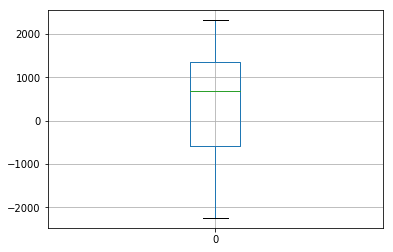


skipping userAE30
user:  AF82  vals:  2222535  mean:  329.6670927566945  std:  1114.2967251811024  min:  -2098  max:  2208
[0 0 0 0] ... [ 1620   328  -661 -1462] ... [2033 -856  525 2073]


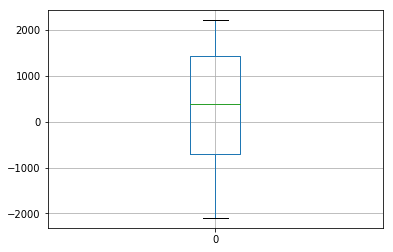


user:  AL29  vals:  3869796  mean:  438.095562401739  std:  1079.5085969790257  min:  -2031  max:  2293
[0 0 0 0] ... [   51  -628 -1899 -1899] ... [2049 -502 1572 1577]


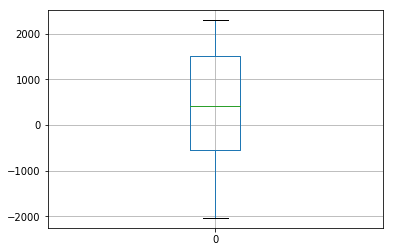


user:  AW18  vals:  2166339  mean:  393.8461182668087  std:  1110.2993550298845  min:  -2305  max:  2338
[0 0 0 0] ... [ 1825   729  -890 -1455] ... [2178  128 1208 1894]


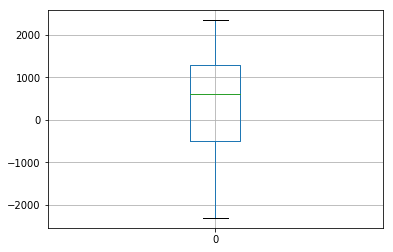


user:  CB23  vals:  2211951  mean:  525.6775321876479  std:  1062.2356617863697  min:  -2179  max:  2353
[-1017   497  1462  -550] ... [1939  520 -172 -299] ... [ 474  195 1970 -495]


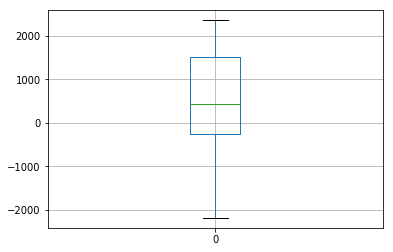


user:  CB24  vals:  2227722  mean:  429.572764465225  std:  988.0063983322849  min:  -1986  max:  2226
[-1117   779  1284  -744] ... [-1283   806  1123  -837] ... [2199  221 1644 1503]


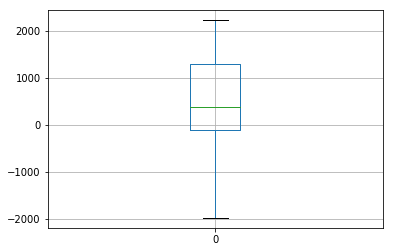


user:  CF58  vals:  2505216  mean:  316.6279530387799  std:  1128.781927770286  min:  -2330  max:  2275
[-1298   396  1310 -1123] ... [-1107    92  1497 -1276] ... [1503 -838 -838 1168]


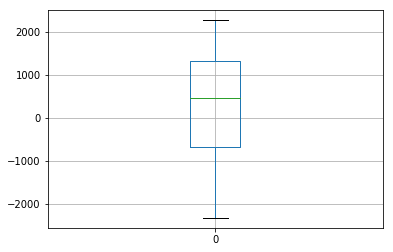


user:  DG12  vals:  2195571  mean:  284.3798925199868  std:  1147.2287898338961  min:  -2559  max:  2333
[-1218   601  1294 -1032] ... [ 1476  1308  -613 -1107] ... [2124 -540  466 2186]


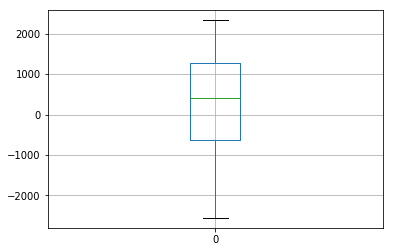


user:  DH42  vals:  2319135  mean:  445.8814264801316  std:  1086.053266591208  min:  -2253  max:  2249
[1718 2243 -447 1858] ... [1626 1102 -734 -747] ... [2129 -344 1113 1927]


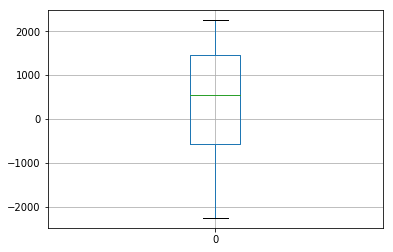


user:  DL24  vals:  3806838  mean:  467.3847271672711  std:  1097.1131596969478  min:  -2205  max:  2454
[-589 1948 -563 -356] ... [-134 2168 -955 -167] ... [1894  -61 2019  549]


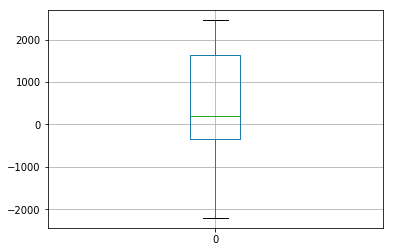


user:  JL61  vals:  2363886  mean:  445.53498349751214  std:  1075.073534807274  min:  -2256  max:  2315
[0 0 0 0] ... [-1182   451  1590 -1200] ... [1943 -538 1900  852]


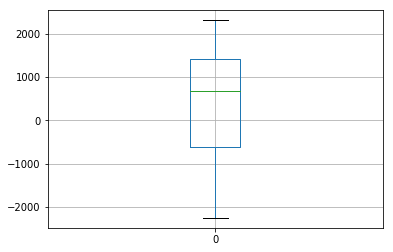


user:  JQ28  vals:  4023516  mean:  480.4964148272307  std:  1064.3357124738918  min:  -2206  max:  2314
[-909  787 1447 -774] ... [-972  838 1414 -846] ... [1026  -61 1832 1316]


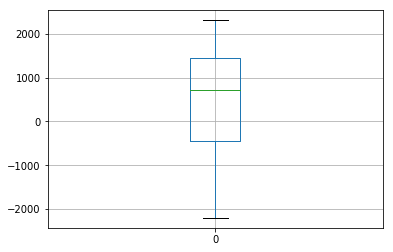


user:  JS52  vals:  3936009  mean:  388.09855338237287  std:  1119.9490491364948  min:  -2372  max:  2440
[-1881   649   -13 -1725] ... [ 1882   450 -1030 -1096] ... [2041   78 1814 1234]


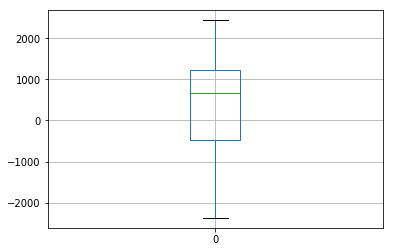


user:  MF20  vals:  2163441  mean:  362.96136525100525  std:  1108.444940012732  min:  -2167  max:  2212
[-1785   784   317 -1238] ... [ 1696   789  -789 -1633] ... [ 698  416 1939 -250]


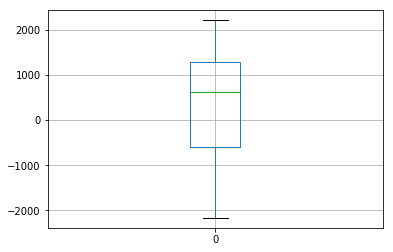


user:  MS55  vals:  2285892  mean:  412.44749751956783  std:  1096.815356904594  min:  -2308  max:  2320
[0 0 0 0] ... [-1023   575  1448  -869] ... [-243  365 1753 -642]


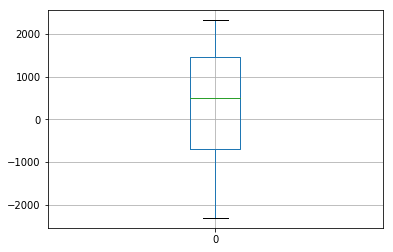


user:  PC29  vals:  2522898  mean:  1438.7687928723237  std:  4540.8552038952  min:  -10986  max:  9480
[-5136 -4928  2380 -5574] ... [-6302  3188  3142 -4654] ... [ 3078 -2394  6404  6592]


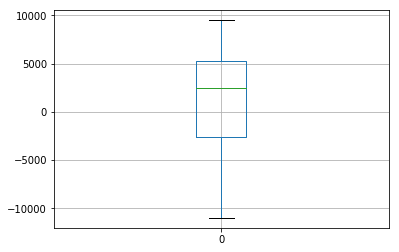


user:  PM32  vals:  3794028  mean:  407.4812363008391  std:  1120.1927688515834  min:  -2685  max:  2465
[0 0 0 0] ... [-846  798 1448 -809] ... [2078 -660  810 2006]


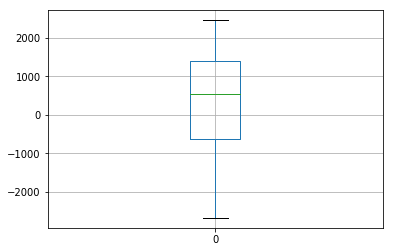


user:  PS42  vals:  2221695  mean:  399.4999124542298  std:  1089.6347618401437  min:  -1959  max:  2208
[0 0 0 0] ... [1649 1042 -898 -929] ... [2075 -356 1074 1923]


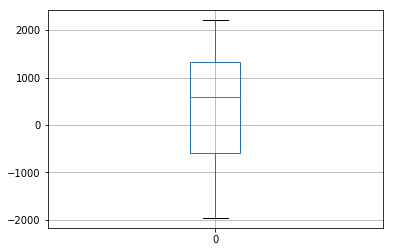


user:  RR45  vals:  2218671  mean:  366.66542403087254  std:  1119.9128046303526  min:  -2419  max:  2423
[-1269   226  1294  -954] ... [ 1422  1297  -793 -1005] ... [1983 -545  210 2182]


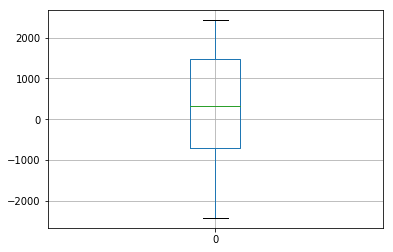


user:  RW32  vals:  2222241  mean:  388.08880719957915  std:  1125.8999138395734  min:  -2656  max:  2364
[-1257   440  1323 -1047] ... [ 1657   997  -671 -1535] ... [ 574  393 1498 2074]


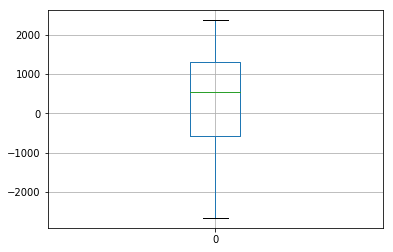


user:  SF1  vals:  2167305  mean:  1638.120914684366  std:  4049.629331813869  min:  -7738  max:  8598
[ 6102  5298 -5444  3608] ... [6900 1788    0    0] ... [ 8268 -1344  4618  7650]


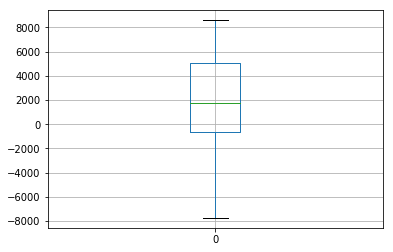


user:  YW13  vals:  3928722  mean:  475.50964079413103  std:  1059.6833659224171  min:  -2283  max:  2316
[ -717  1195 -1789  -823] ... [-1022   926  1325  -730] ... [1637  203 2042 -142]


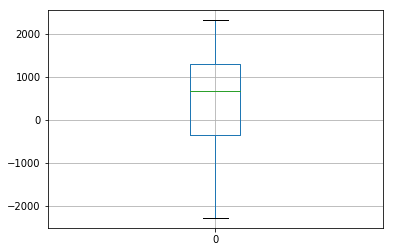

In [35]:
show_boxplots(cols[all_accel], True, False)

In [14]:
all_gyro = Constants().raw_indices['gyro']
print(cols[all_gyro])

Index(['21_Finger_1_Gyro_X', '22_Finger_1_Gyro_Y', '23_Finger_1_Gyro_Z',
       '27_Finger_2_Gyro_X', '28_Finger_2_Gyro_Y', '29_Finger_2_Gyro_Z',
       '33_Finger_3_Gyro_X', '34_Finger_3_Gyro_Y', '35_Finger_3_Gyro_Z',
       '39_Finger_4_Gyro_X', '40_Finger_4_Gyro_Y', '41_Finger_4_Gyro_Z',
       '45_Thumb_Gyro_X', '46_Thumb_Gyro_Y', '47_Thumb_Gyro_Z',
       '51_Palm_Gyro_X', '52_Palm_Gyro_Y', '53_Palm_Gyro_Z', '57_Wrist_Gyro_X',
       '58_Wrist_Gyro_Y', '59_Wrist_Gyro_Z'],
      dtype='object')


In [37]:
describe_value_range(cols[all_gyro], True, False)

user: AB73
                  0
count  3.843168e+06
mean  -1.524872e+01
std    7.369976e+02
min   -3.623000e+03
25%   -4.300000e+01
50%   -1.000000e+00
75%    3.800000e+01
max    3.490000e+03

skipping userAE30
user: AF82
                  0
count  2.222535e+06
mean  -1.009352e+01
std    6.580186e+02
min   -3.211000e+03
25%   -4.300000e+01
50%   -3.000000e+00
75%    3.100000e+01
max    3.287000e+03

user: AL29
                  0
count  3.869796e+06
mean  -1.501949e+01
std    6.743646e+02
min   -3.154000e+03
25%   -4.200000e+01
50%   -3.000000e+00
75%    3.000000e+01
max    3.172000e+03

user: AW18
                  0
count  2.166339e+06
mean  -1.664590e+01
std    6.459756e+02
min   -3.408000e+03
25%   -3.700000e+01
50%   -3.000000e+00
75%    3.300000e+01
max    3.081000e+03

user: CB23
                  0
count  2.211951e+06
mean  -1.660161e+01
std    5.905053e+02
min   -2.990000e+03
25%   -5.300000e+01
50%   -7.000000e+00
75%    4.400000e+01
max    2.667000e+03

user: CB24
           

user:  AB73  vals:  3843168  mean:  425.3108745181059  std:  1096.0314146935139  min:  -2247  max:  2313
[-488  897 1540 -880] ... [-1553   736   918 -1277] ... [2033    7 1532 1586]


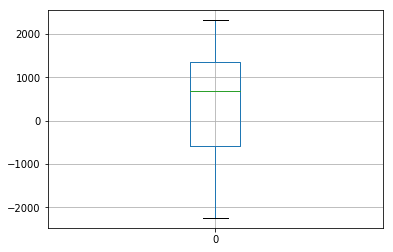


skipping userAE30
user:  AF82  vals:  2222535  mean:  329.6670927566945  std:  1114.2967251811024  min:  -2098  max:  2208
[0 0 0 0] ... [ 1620   328  -661 -1462] ... [2033 -856  525 2073]


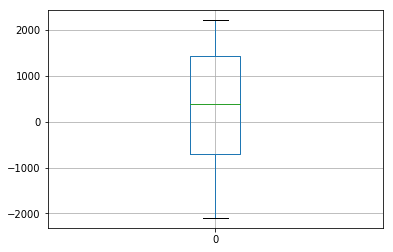


user:  AL29  vals:  3869796  mean:  438.095562401739  std:  1079.5085969790257  min:  -2031  max:  2293
[0 0 0 0] ... [   51  -628 -1899 -1899] ... [2049 -502 1572 1577]


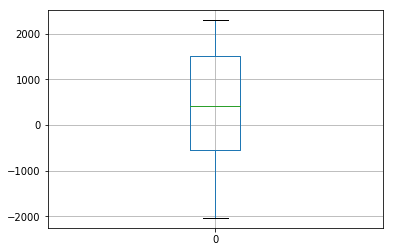


user:  AW18  vals:  2166339  mean:  393.8461182668087  std:  1110.2993550298845  min:  -2305  max:  2338
[0 0 0 0] ... [ 1825   729  -890 -1455] ... [2178  128 1208 1894]


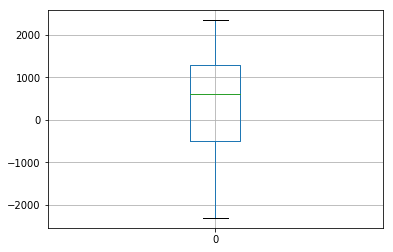


user:  CB23  vals:  2211951  mean:  525.6775321876479  std:  1062.2356617863697  min:  -2179  max:  2353
[-1017   497  1462  -550] ... [1939  520 -172 -299] ... [ 474  195 1970 -495]


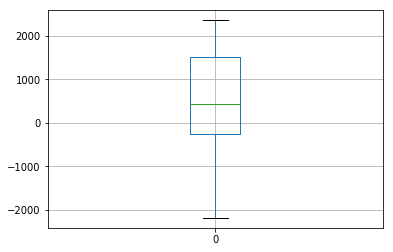


user:  CB24  vals:  2227722  mean:  429.572764465225  std:  988.0063983322849  min:  -1986  max:  2226
[-1117   779  1284  -744] ... [-1283   806  1123  -837] ... [2199  221 1644 1503]


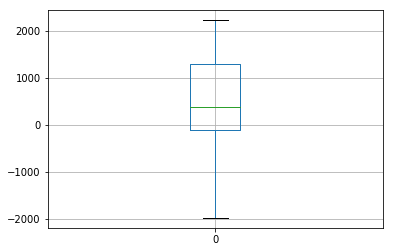


user:  CF58  vals:  2505216  mean:  316.6279530387799  std:  1128.781927770286  min:  -2330  max:  2275
[-1298   396  1310 -1123] ... [-1107    92  1497 -1276] ... [1503 -838 -838 1168]


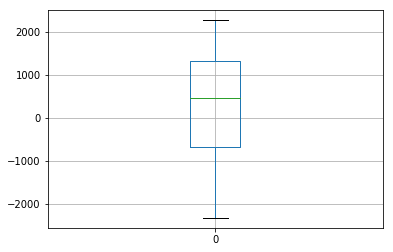


user:  DG12  vals:  2195571  mean:  284.3798925199868  std:  1147.2287898338961  min:  -2559  max:  2333
[-1218   601  1294 -1032] ... [ 1476  1308  -613 -1107] ... [2124 -540  466 2186]


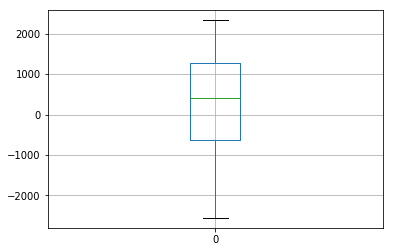


user:  DH42  vals:  2319135  mean:  445.8814264801316  std:  1086.053266591208  min:  -2253  max:  2249
[1718 2243 -447 1858] ... [1626 1102 -734 -747] ... [2129 -344 1113 1927]


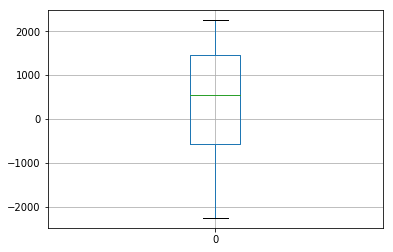


user:  DL24  vals:  3806838  mean:  467.3847271672711  std:  1097.1131596969478  min:  -2205  max:  2454
[-589 1948 -563 -356] ... [-134 2168 -955 -167] ... [1894  -61 2019  549]


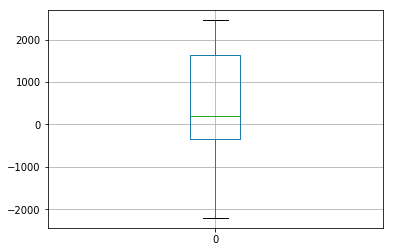


user:  JL61  vals:  2363886  mean:  445.53498349751214  std:  1075.073534807274  min:  -2256  max:  2315
[0 0 0 0] ... [-1182   451  1590 -1200] ... [1943 -538 1900  852]


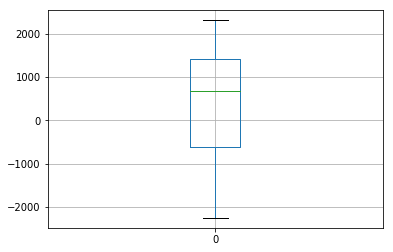


user:  JQ28  vals:  4023516  mean:  480.4964148272307  std:  1064.3357124738918  min:  -2206  max:  2314
[-909  787 1447 -774] ... [-972  838 1414 -846] ... [1026  -61 1832 1316]


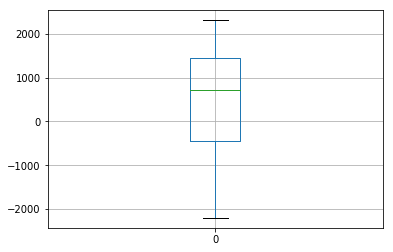


user:  JS52  vals:  3936009  mean:  388.09855338237287  std:  1119.9490491364948  min:  -2372  max:  2440
[-1881   649   -13 -1725] ... [ 1882   450 -1030 -1096] ... [2041   78 1814 1234]


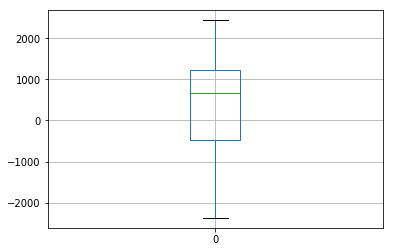


user:  MF20  vals:  2163441  mean:  362.96136525100525  std:  1108.444940012732  min:  -2167  max:  2212
[-1785   784   317 -1238] ... [ 1696   789  -789 -1633] ... [ 698  416 1939 -250]


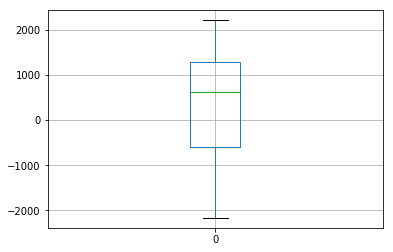


user:  MS55  vals:  2285892  mean:  412.44749751956783  std:  1096.815356904594  min:  -2308  max:  2320
[0 0 0 0] ... [-1023   575  1448  -869] ... [-243  365 1753 -642]


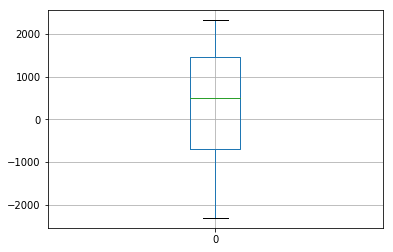


user:  PC29  vals:  2522898  mean:  1438.7687928723237  std:  4540.8552038952  min:  -10986  max:  9480
[-5136 -4928  2380 -5574] ... [-6302  3188  3142 -4654] ... [ 3078 -2394  6404  6592]


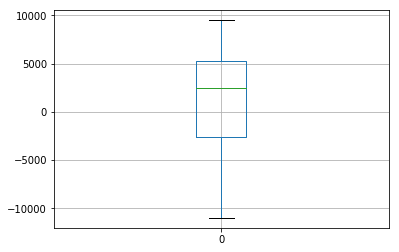


user:  PM32  vals:  3794028  mean:  407.4812363008391  std:  1120.1927688515834  min:  -2685  max:  2465
[0 0 0 0] ... [-846  798 1448 -809] ... [2078 -660  810 2006]


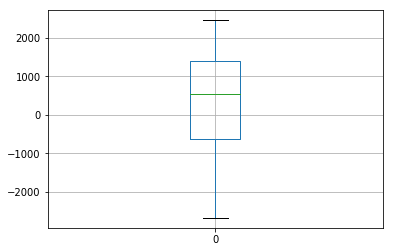


user:  PS42  vals:  2221695  mean:  399.4999124542298  std:  1089.6347618401437  min:  -1959  max:  2208
[0 0 0 0] ... [1649 1042 -898 -929] ... [2075 -356 1074 1923]


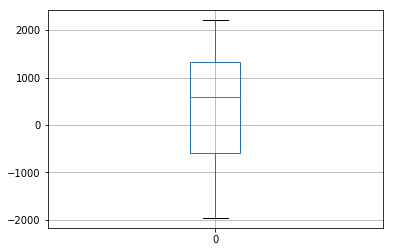


user:  RR45  vals:  2218671  mean:  366.66542403087254  std:  1119.9128046303526  min:  -2419  max:  2423
[-1269   226  1294  -954] ... [ 1422  1297  -793 -1005] ... [1983 -545  210 2182]


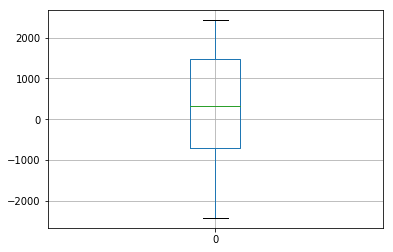


user:  RW32  vals:  2222241  mean:  388.08880719957915  std:  1125.8999138395734  min:  -2656  max:  2364
[-1257   440  1323 -1047] ... [ 1657   997  -671 -1535] ... [ 574  393 1498 2074]


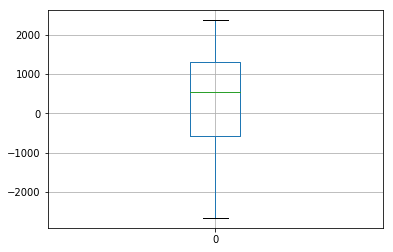


user:  SF1  vals:  2167305  mean:  1638.120914684366  std:  4049.629331813869  min:  -7738  max:  8598
[ 6102  5298 -5444  3608] ... [6900 1788    0    0] ... [ 8268 -1344  4618  7650]


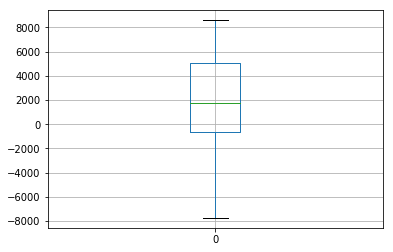


user:  YW13  vals:  3928722  mean:  475.50964079413103  std:  1059.6833659224171  min:  -2283  max:  2316
[ -717  1195 -1789  -823] ... [-1022   926  1325  -730] ... [1637  203 2042 -142]


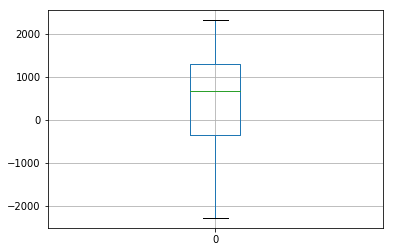

In [38]:
show_boxplots(cols[all_gyro], True, False)

In [15]:
all_flex = Constants().raw_indices['flex']['all']
print(cols[all_flex])

Index(['0_Thumb_base', '2_Angle_between_thumb_and_hand', '3_Finger_1_base',
       '4_Finger_1_tip', '5_Finger_2_base', '6_Finger_2_tip',
       '7_Finger_3_base', '8_Finger_3_tip', '9_Finger_4_base',
       '10_Finger_4_tip', '11_Thumb_tip', '16_Wrist_extension',
       '17_Wrist_flexion'],
      dtype='object')


In [40]:
describe_value_range(cols[all_flex], True, False)

user: AB73
                  0
count  2.379104e+06
mean   1.772701e+03
std    2.868182e+02
min    1.136000e+03
25%    1.624000e+03
50%    1.803000e+03
75%    1.975000e+03
max    2.314000e+03

skipping userAE30
user: AF82
                  0
count  1.375855e+06
mean   1.755300e+03
std    2.675732e+02
min    1.162000e+03
25%    1.629000e+03
50%    1.759000e+03
75%    1.931000e+03
max    2.282000e+03

user: AL29
                  0
count  2.395588e+06
mean   1.698773e+03
std    2.545248e+02
min    1.166000e+03
25%    1.592000e+03
50%    1.718000e+03
75%    1.857000e+03
max    2.222000e+03

user: AW18
                  0
count  1.341067e+06
mean   1.709894e+03
std    2.943142e+02
min    1.093000e+03
25%    1.600000e+03
50%    1.725000e+03
75%    1.909000e+03
max    2.250000e+03

user: CB23
                  0
count  1.369303e+06
mean   1.754792e+03
std    3.325143e+02
min    1.039000e+03
25%    1.623000e+03
50%    1.806000e+03
75%    1.997000e+03
max    2.309000e+03

user: CB24
           

user:  AB73  vals:  3843168  mean:  425.3108745181059  std:  1096.0314146935139  min:  -2247  max:  2313
[-488  897 1540 -880] ... [-1553   736   918 -1277] ... [2033    7 1532 1586]


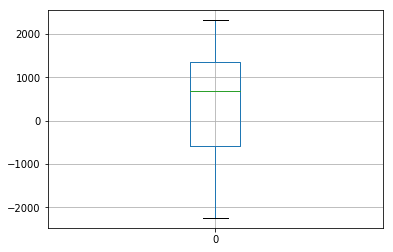


skipping userAE30
user:  AF82  vals:  2222535  mean:  329.6670927566945  std:  1114.2967251811024  min:  -2098  max:  2208
[0 0 0 0] ... [ 1620   328  -661 -1462] ... [2033 -856  525 2073]


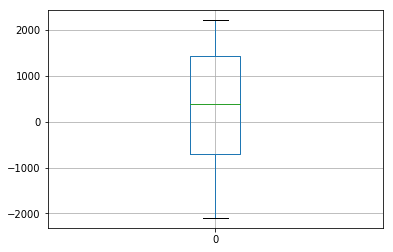


user:  AL29  vals:  3869796  mean:  438.095562401739  std:  1079.5085969790257  min:  -2031  max:  2293
[0 0 0 0] ... [   51  -628 -1899 -1899] ... [2049 -502 1572 1577]


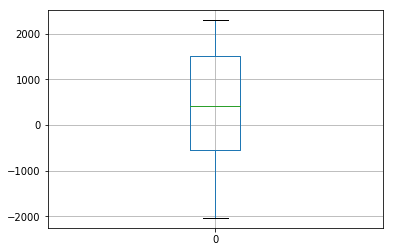


user:  AW18  vals:  2166339  mean:  393.8461182668087  std:  1110.2993550298845  min:  -2305  max:  2338
[0 0 0 0] ... [ 1825   729  -890 -1455] ... [2178  128 1208 1894]


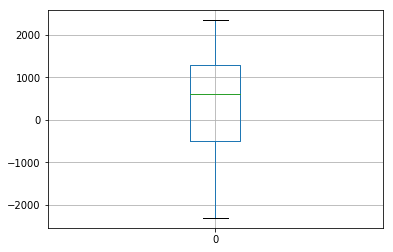


user:  CB23  vals:  2211951  mean:  525.6775321876479  std:  1062.2356617863697  min:  -2179  max:  2353
[-1017   497  1462  -550] ... [1939  520 -172 -299] ... [ 474  195 1970 -495]


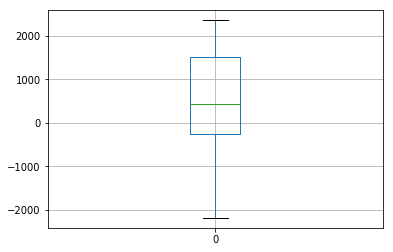


user:  CB24  vals:  2227722  mean:  429.572764465225  std:  988.0063983322849  min:  -1986  max:  2226
[-1117   779  1284  -744] ... [-1283   806  1123  -837] ... [2199  221 1644 1503]


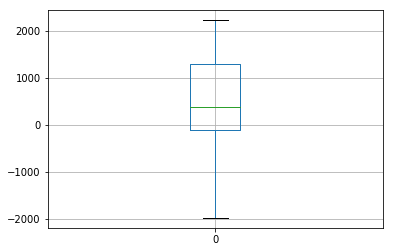


user:  CF58  vals:  2505216  mean:  316.6279530387799  std:  1128.781927770286  min:  -2330  max:  2275
[-1298   396  1310 -1123] ... [-1107    92  1497 -1276] ... [1503 -838 -838 1168]


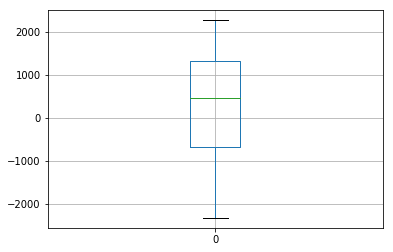


user:  DG12  vals:  2195571  mean:  284.3798925199868  std:  1147.2287898338961  min:  -2559  max:  2333
[-1218   601  1294 -1032] ... [ 1476  1308  -613 -1107] ... [2124 -540  466 2186]


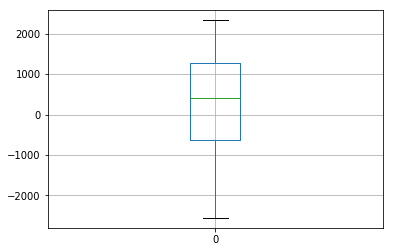


user:  DH42  vals:  2319135  mean:  445.8814264801316  std:  1086.053266591208  min:  -2253  max:  2249
[1718 2243 -447 1858] ... [1626 1102 -734 -747] ... [2129 -344 1113 1927]


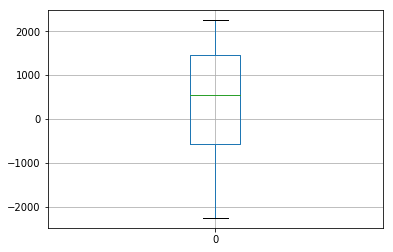


user:  DL24  vals:  3806838  mean:  467.3847271672711  std:  1097.1131596969478  min:  -2205  max:  2454
[-589 1948 -563 -356] ... [-134 2168 -955 -167] ... [1894  -61 2019  549]


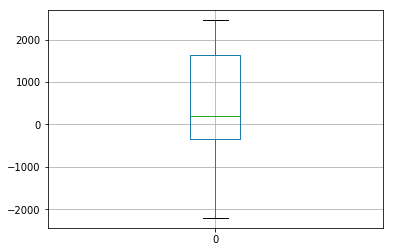


user:  JL61  vals:  2363886  mean:  445.53498349751214  std:  1075.073534807274  min:  -2256  max:  2315
[0 0 0 0] ... [-1182   451  1590 -1200] ... [1943 -538 1900  852]


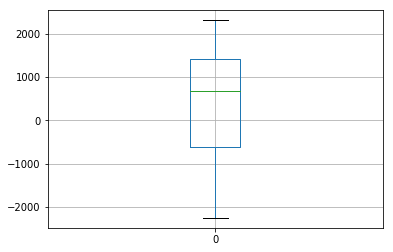


user:  JQ28  vals:  4023516  mean:  480.4964148272307  std:  1064.3357124738918  min:  -2206  max:  2314
[-909  787 1447 -774] ... [-972  838 1414 -846] ... [1026  -61 1832 1316]


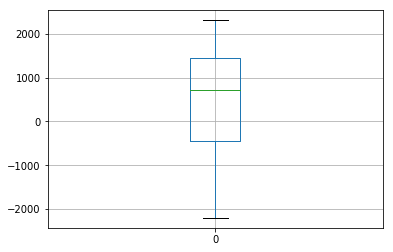


user:  JS52  vals:  3936009  mean:  388.09855338237287  std:  1119.9490491364948  min:  -2372  max:  2440
[-1881   649   -13 -1725] ... [ 1882   450 -1030 -1096] ... [2041   78 1814 1234]


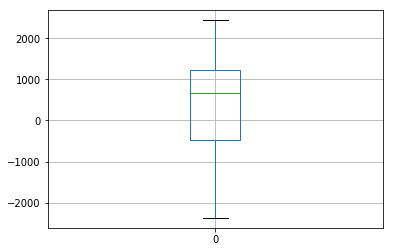


user:  MF20  vals:  2163441  mean:  362.96136525100525  std:  1108.444940012732  min:  -2167  max:  2212
[-1785   784   317 -1238] ... [ 1696   789  -789 -1633] ... [ 698  416 1939 -250]


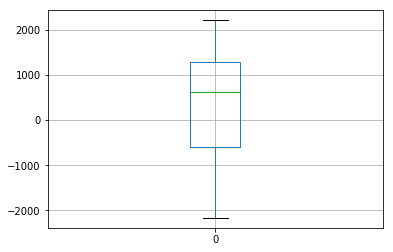


user:  MS55  vals:  2285892  mean:  412.44749751956783  std:  1096.815356904594  min:  -2308  max:  2320
[0 0 0 0] ... [-1023   575  1448  -869] ... [-243  365 1753 -642]


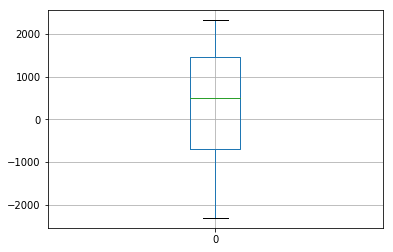


user:  PC29  vals:  2522898  mean:  1438.7687928723237  std:  4540.8552038952  min:  -10986  max:  9480
[-5136 -4928  2380 -5574] ... [-6302  3188  3142 -4654] ... [ 3078 -2394  6404  6592]


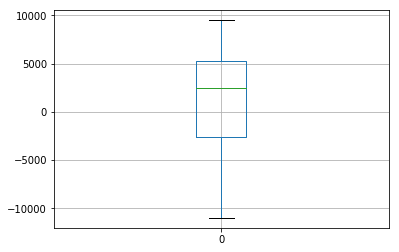


user:  PM32  vals:  3794028  mean:  407.4812363008391  std:  1120.1927688515834  min:  -2685  max:  2465
[0 0 0 0] ... [-846  798 1448 -809] ... [2078 -660  810 2006]


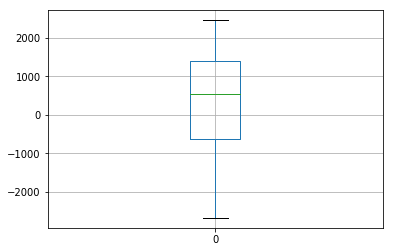


user:  PS42  vals:  2221695  mean:  399.4999124542298  std:  1089.6347618401437  min:  -1959  max:  2208
[0 0 0 0] ... [1649 1042 -898 -929] ... [2075 -356 1074 1923]


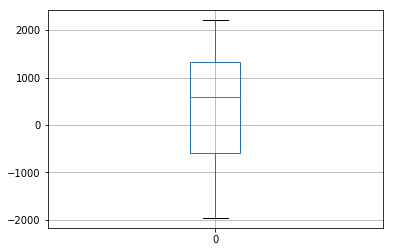


user:  RR45  vals:  2218671  mean:  366.66542403087254  std:  1119.9128046303526  min:  -2419  max:  2423
[-1269   226  1294  -954] ... [ 1422  1297  -793 -1005] ... [1983 -545  210 2182]


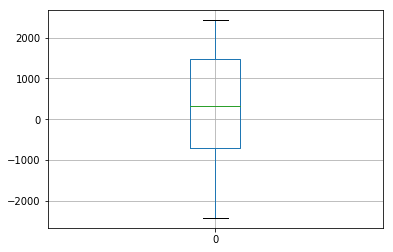


user:  RW32  vals:  2222241  mean:  388.08880719957915  std:  1125.8999138395734  min:  -2656  max:  2364
[-1257   440  1323 -1047] ... [ 1657   997  -671 -1535] ... [ 574  393 1498 2074]


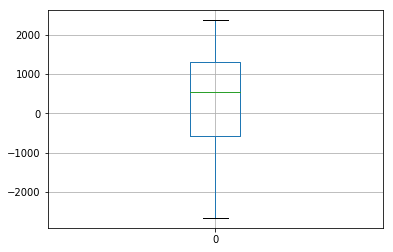


user:  SF1  vals:  2167305  mean:  1638.120914684366  std:  4049.629331813869  min:  -7738  max:  8598
[ 6102  5298 -5444  3608] ... [6900 1788    0    0] ... [ 8268 -1344  4618  7650]


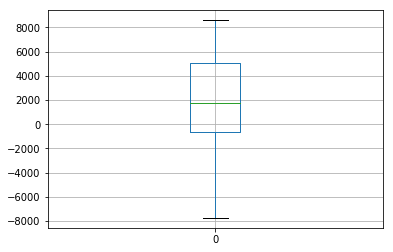


user:  YW13  vals:  3928722  mean:  475.50964079413103  std:  1059.6833659224171  min:  -2283  max:  2316
[ -717  1195 -1789  -823] ... [-1022   926  1325  -730] ... [1637  203 2042 -142]


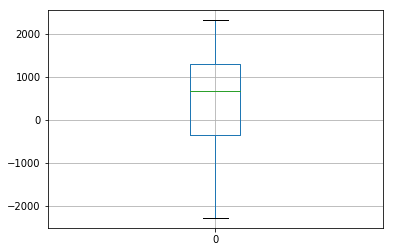

In [41]:
show_boxplots(cols[all_flex], True, False)

user:  AB73  vals:  3843168  mean:  425.3108745181059  std:  1096.0314146935139  min:  -2247  max:  2313
[-488  897 1540 -880] ... [-1553   736   918 -1277] ... [2033    7 1532 1586]

skipping userAE30
user:  AF82  vals:  2222535  mean:  329.6670927566945  std:  1114.2967251811024  min:  -2098  max:  2208
[0 0 0 0] ... [ 1620   328  -661 -1462] ... [2033 -856  525 2073]

user:  AL29  vals:  3869796  mean:  438.095562401739  std:  1079.5085969790257  min:  -2031  max:  2293
[0 0 0 0] ... [   51  -628 -1899 -1899] ... [2049 -502 1572 1577]

user:  AW18  vals:  2166339  mean:  393.8461182668087  std:  1110.2993550298845  min:  -2305  max:  2338
[0 0 0 0] ... [ 1825   729  -890 -1455] ... [2178  128 1208 1894]

user:  CB23  vals:  2211951  mean:  525.6775321876479  std:  1062.2356617863697  min:  -2179  max:  2353
[-1017   497  1462  -550] ... [1939  520 -172 -299] ... [ 474  195 1970 -495]

user:  CB24  vals:  2227722  mean:  429.572764465225  std:  988.0063983322849  min:  -1986  max:  2

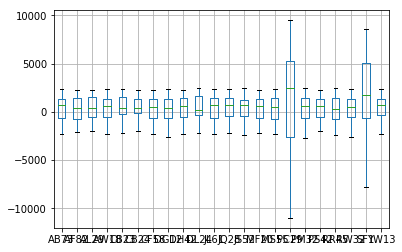

In [57]:
show_boxplots_row(cols[all_flex], True, False)

In [ ]:
# so, the next step in the story is this: 
# Are these variations mainly the 0 class or mainly the 
# way gestures are done?
# 
# To prove that I seperate the data into clearly 0 class 
# instances (everything outside the automatic) labeling,
# and into clearly geatures (everything inside the manual
# labeling)

In [25]:
def show_boxplots_row_lc(columes, label_type, label, remove_outliers, show_overal):
    all_vals = []
    all_dfs = []
    for username in usernames:
        if not 'glove_merged' in users[username]:
            print('skipping user' + username)
            continue
        glove_merged = users[username]['glove_merged'] 
        if label is np.nan:
            accel = glove_merged[glove_merged[label_type].isnull()][cols[all_accel]]
        elif label == 'all_labels':
            accel = glove_merged[glove_merged[label_type].notnull()][cols[all_accel]]
        else:
            accel = glove_merged[glove_merged[label_type] == gesture][cols[all_accel]]
        onebigline = accel.values.ravel()
        n = len(onebigline)
        nh = n//2
        if remove_outliers:
            remove_higher_outliers_with_percentile(onebigline, higher_percentile)
            remove_lower_outliers_with_percentile(onebigline, lower_percentile)
        print('user: ', username, ' vals: ', n, ' mean: ', onebigline.mean(), ' std: ', onebigline.std(), ' min: ', onebigline.min(), ' max: ', onebigline.max())
        print(onebigline[:4], "...", onebigline[nh:nh+4], "...",onebigline[-4:])
        
        if show_overal:
            all_vals += list(onebigline)
        df = pd.DataFrame(data=onebigline.T, columns= [username])
        all_dfs.append(df)
        print("")
    df = pd.concat(all_dfs, axis=1) 
    print(df)
    df.boxplot()
    plt.show()
    if show_overal:
        n = len(all_vals)
        nh = n//2
        print(all_vals[:4], "...", all_vals[nh:nh+4], "...",all_vals[-4:])
        pd.DataFrame(data=all_vals).T.boxplot()
        plt.show()

user:  AB73  vals:  2175747  mean:  476.68175849489853  std:  1030.2249295757315  min:  -1449  max:  2114
[-488  897 1540 -880] ... [ 1878   563  -818 -1164] ... [2066   35 1483 1685]

skipping userAE30
user:  AF82  vals:  1384950  mean:  363.76093938409326  std:  1072.4137864112483  min:  -1521  max:  2123
[0 0 0 0] ... [-866  445 1569 -862] ... [1963 -864  590 2014]

user:  AL29  vals:  2220036  mean:  478.7479716545137  std:  1039.2547953771661  min:  -1231  max:  2100
[0 0 0 0] ... [-766   58 1683 -798] ... [2079 -365 1520 1652]

user:  AW18  vals:  1347087  mean:  433.78241197487614  std:  1051.7442331411087  min:  -1502  max:  2182
[0 0 0 0] ... [ 1822   713  -840 -1473] ... [ 160   75 1170 1922]

user:  CB23  vals:  1392384  mean:  561.8138502022431  std:  1007.5457595857774  min:  -1979  max:  2116
[-1017   497  1462  -550] ... [-747 1812 -750 -176] ... [ 791  156 2027 -236]

user:  CB24  vals:  1397613  mean:  479.04279940155106  std:  934.1160285610786  min:  -1508  max:  219

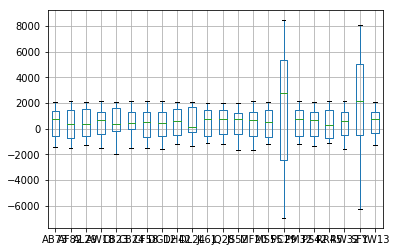

In [22]:
show_boxplots_row_lc(cols[all_accel], 'label_automatic', np.nan, True, False)

user:  AB73  vals:  599592  mean:  254.53898150742504  std:  1330.0691699002891  min:  -4288  max:  3149
[1422 -864 1179  567] ... [ -564  1471 -1455  -182] ... [1675  728 1343 1315]

skipping userAE30
user:  AF82  vals:  293979  mean:  225.2880511873297  std:  1313.2963382051369  min:  -3893  max:  3055
[ -964   376   830 -1009] ... [ 1982 -1098 -1596  -205] ... [1822  -49  955 1894]

user:  AL29  vals:  596736  mean:  330.7598334942085  std:  1315.1331884174274  min:  -4190  max:  3382
[ 1769  1627 -3624   840] ... [  761  -124 -1144   590] ... [1056  508 1906  448]

user:  AW18  vals:  340872  mean:  177.60652972376727  std:  1468.7025165211112  min:  -5515  max:  3846
[-616 1258  849 -708] ... [ 2416  2864 -4889  1068] ... [2245  628 1159 1858]

user:  CB23  vals:  390642  mean:  327.9645404232008  std:  1288.2672973781675  min:  -3914  max:  3193
[-661  809  517 -716] ... [-1172    67 -1728  -935] ... [1485 1053 1073  766]

user:  CB24  vals:  284739  mean:  184.54307980290722  st

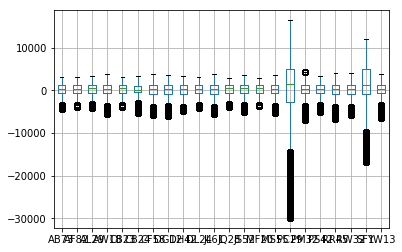

In [26]:
show_boxplots_row_lc(cols[all_accel], 'label_manual', 'all_labels', True, False)